## Starter notebook for MLP ansatz for Helium

1. Energy - using Hessian,
2. Gradients - using known formula (update manually),
3. Optimization - ADAM.

First, non-symmetric, without Jastrow factor, to slowly add complexity

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch import vmap
from functorch import make_functional, vmap, grad
import matplotlib.pyplot as plt


torch.set_default_dtype(torch.float64)

from nn import model, psi_nn

model = model.double()

### Model definition

In [2]:
device = torch.device('cuda')
cpu = torch.device('cpu')

### Metropolis sampling

In [3]:
def metropolis(N: int, pos: torch.tensor, n_runs: int, model):  
    
    L = 0.5
    
    r1 = pos[:, :3]
    r2 = pos[:, 3:]

    #sampled_Xs = []
    accept_count = 0

    for _ in range(N):
        chose = torch.rand(n_runs, 1)

        perturbed_r1 = r1 + L * torch.randn(n_runs, 3)
        perturbed_r2 = r2 + L * torch.randn(n_runs, 3)

        r1_trial = torch.where(chose < 0.5, perturbed_r1, r1)
        r2_trial = torch.where(chose >= 0.5, perturbed_r2, r2)

        x_old = torch.cat((r1, r2), dim=1)
        x_trial = torch.cat((r1_trial, r2_trial), dim=1)

        psi_val = psi_nn(x_old, model, return_log=True)
        psi_trial_val = psi_nn(x_trial, model, return_log=True)

        #psi_ratio = (psi_trial_val / psi_val) ** 2
        psi_ratio = torch.exp(2 * (psi_trial_val - psi_val)) 

        rand_uniform = torch.rand(n_runs)

        accepted = psi_ratio > rand_uniform
        accept_count += accepted.sum().item()

        mask = accepted.unsqueeze(1)

        r1 = torch.where(mask, r1_trial, r1)
        r2 = torch.where(mask, r2_trial, r2)

        #sampled_Xs.append(torch.cat((r1, r2), dim=1))

    acceptance_ratio = accept_count / (N * n_runs)
    #print(f"Acceptance ratio: {acceptance_ratio:.4f}")

    return torch.cat((r1, r2), dim=1)
    #return torch.stack(sampled_Xs)


### Local energy

In [4]:

def local_energy(positions, model):
    positions = positions.clone().detach().requires_grad_(True)

    r1_vec = positions[:, 0:3]
    r2_vec = positions[:, 3:6]

    r1 = torch.norm(r1_vec, dim=1, keepdim=True)
    r2 = torch.norm(r2_vec, dim=1, keepdim=True)
    r12 = torch.norm(r1_vec - r2_vec, dim=1, keepdim=True)

    scalar_features = torch.cat([r1, r2, r12], dim=1)

    log_psi_val = psi_nn(positions, model, return_log=False)

    grad_log_psi = torch.autograd.grad(
        log_psi_val.sum(), positions, create_graph=True)[0]

    laplacian = torch.zeros_like(log_psi_val)
    for i in range(positions.shape[1]):
        grad_i = grad_log_psi[:, i]
        grad2_i = torch.autograd.grad(
            grad_i.sum(), positions, create_graph=True
        )[0][:, i]
        laplacian += grad2_i

    kinetic = -0.5 * (laplacian/log_psi_val)

    # Potential energy: -2/r1 -2/r2 + 1/r12
    eps = 0  # avoid div by 0
    potential = -2 / (r1.squeeze() + eps) - 2 / (r2.squeeze() + eps) + 1 / (r12.squeeze() + eps)

    return kinetic + potential

def get_local_energy(sampled_Xs, model):

    local_E = local_energy(sampled_Xs, model) # N_walkers * N, 1
    return local_E
 

### Gradients

In [ ]:

def parameter_gradients(x, E, model):
    
    fmodel, params = make_functional(model)

    def psi_func(params, x):
        return fmodel(params, x.unsqueeze(0)).squeeze()

    grad_log_psi = grad(psi_func)

    grads = vmap(grad_log_psi, in_dims=(None, 0))(params, x)
    flat_grads = torch.cat([g.reshape(x.shape[0], -1) for g in grads], dim=1)
    
    n_parameters = flat_grads.shape[-1]

    mean_grad = torch.mean(flat_grads, axis=0) # across walkers - (Np)
    E = E.flatten()
    mean_E = torch.mean(E)

    centered_E = E - mean_E  # (Ns x Np)
    centered_grads = flat_grads - mean_grad

    print(centered_grads.shape)

    # SR
    metric_tensor = (
        centered_grads.T @ centered_grads) / centered_grads.shape[0]  # this is the effective average
    
    print(metric_tensor.shape)

    # MinSR
    metric_tensor = (
        centered_grads @ centered_grads.T) / centered_grads.shape[0]

    print(metric_tensor.shape)
    """ Psuedo inverse tricks using eigendecomp
    L, V = torch.linalg.eig(metric_tensor)
    L = torch.real(L)
    L = torch.where(L > 1e-3, 1/L, 0)
    V  = torch.real(V)
    psuedo_inverse = V[0] @ L * V[1]
    """

    #metric_tensor = metric_tensor[:-1, :-1]  # Last parameter is unused causing all the probls
    
    # Pre-conditioning
    #outer = metric_diag.unsqueeze(0) * metric_diag.unsqueeze(1)
    #pc_matrix = 1 / torch.sqrt(outer)
    #metric_tensor = metric_tensor @ pc_matrix
    #metric_diag = torch.diag(metric_tensor)

    # Sorella's trick
    delta = 1e-3
    metric_tensor = metric_tensor + (delta * torch.eye(
        metric_tensor.shape[0]).to(device))  # Sorella's trick for zero eigenvalues
    
    #grad_pc = torch.sqrt(metric_diag)
    #grads = centered_grads.T * centered_E
    #grads_pc = (grads.T * grad_pc).T
    #grads = torch.mean(
    #    grads_pc, axis=1)

    grads = torch.mean(grads, axis=1)

    # Using solve
    #grads = torch.linalg.solve(metric_tensor, grads)
    grads = torch.linalg.solve(grads, metric_tensor)
    #inv = torch.linalg.inv(metric_tensor)
    #grads = torch.matmul(inv, grads)
    
    return grads.reshape(n_parameters, 1)

def get_parameter_gradients(sampled_Xs, local_E, model):
    return parameter_gradients(sampled_Xs, local_E, model)


In [20]:
model

MLP(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [19]:
metric_diag[-4:]

tensor([1.4110e-04, 3.6293e-04, 4.2809e-05, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [23]:

metric_tensor = get_parameter_gradients(grad_Xs, local_E, model)[:-1, :-1]

# Pre-conditioning
metric_diag = torch.diag(metric_tensor)
outer = metric_diag.unsqueeze(0) * metric_diag.unsqueeze(1)
pc_matrix = 1 / torch.sqrt(outer)
metric_tensor_ = metric_tensor @ pc_matrix

# Sorella's trick
#delta = 1e-3
#metric_tensor = metric_tensor + (delta * torch.eye(
#    metric_tensor.shape[0]).to(device))  # Sorella's trick for zero eigenvalues

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\_functorch\deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\_functorch\deprecated.py:65: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs

In [24]:
pc_matrix

tensor([[37728.4442, 44342.1652, 33679.6536,  ..., 16351.9925, 10195.7834,
         29686.9913],
        [44342.1652, 52115.2583, 39583.6297,  ..., 19218.4641, 11983.0839,
         34891.0616],
        [33679.6536, 39583.6297, 30065.3550,  ..., 14597.1946,  9101.6330,
         26501.1613],
        ...,
        [16351.9925, 19218.4641, 14597.1946,  ...,  7087.1636,  4418.9835,
         12866.7235],
        [10195.7834, 11983.0839,  9101.6330,  ...,  4418.9835,  2755.3217,
          8022.6508],
        [29686.9913, 34891.0616, 26501.1613,  ..., 12866.7235,  8022.6508,
         23359.4963]], device='cuda:0', grad_fn=<MulBackward0>)

In [25]:
metric_tensor

tensor([[ 2.6505e-05, -2.3502e-06,  1.7737e-05,  ...,  3.3586e-05,
         -9.6964e-05, -5.6447e-07],
        [-2.3502e-06,  1.9188e-05,  1.1604e-05,  ..., -3.6051e-06,
          1.0684e-05,  7.3987e-06],
        [ 1.7737e-05,  1.1604e-05,  3.3261e-05,  ...,  5.6672e-05,
         -7.2608e-05, -1.7315e-05],
        ...,
        [ 3.3586e-05, -3.6051e-06,  5.6672e-05,  ...,  1.4110e-04,
         -1.4948e-04, -6.3526e-05],
        [-9.6964e-05,  1.0684e-05, -7.2608e-05,  ..., -1.4948e-04,
          3.6293e-04,  1.9435e-05],
        [-5.6447e-07,  7.3987e-06, -1.7315e-05,  ..., -6.3526e-05,
          1.9435e-05,  4.2809e-05]], device='cuda:0', grad_fn=<SliceBackward0>)

In [28]:
eigenvalues, eigenvectors = torch.linalg.eig(metric_tensor)

In [29]:
eigenvalues

tensor([ 1.7785e-02+0.j,  1.0425e-02+0.j,  2.5352e-03+0.j,  ...,
        -3.4365e-25+0.j,  1.6074e-25+0.j,  1.8015e-24+0.j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)

In [32]:
inv = torch.linalg.inv(metric_tensor_)

In [33]:
inv

tensor([[-1.6615e+11, -4.0064e+11,  1.0840e+11,  ..., -2.8284e+11,
         -7.2541e+10,  1.8031e+11],
        [ 2.7921e+11,  1.4376e+12,  8.9777e+10,  ...,  8.6442e+11,
          2.1799e+11,  2.4478e+12],
        [-1.6807e+11, -7.3552e+11,  1.6067e+11,  ..., -7.1868e+11,
         -1.6934e+11, -2.0843e+12],
        ...,
        [ 5.1562e+11, -5.1230e+11,  4.0839e+11,  ...,  5.0340e+11,
          5.2756e+10,  2.2524e+12],
        [ 1.6603e+11, -8.4117e+11,  1.2577e+12,  ..., -2.9813e+11,
         -7.9882e+10, -3.1226e+12],
        [-1.3282e+11, -1.1447e+12,  1.8219e+11,  ..., -6.8533e+11,
         -1.5011e+11, -2.1140e+12]], device='cuda:0',
       grad_fn=<LinalgInvExBackward0>)

In [24]:
metric_tensor.shape

torch.Size([2273, 2273])

In [28]:
t = torch.where(eigenvalues == 0, True, False)

In [29]:
sum(t)

tensor(0, device='cuda:0')

### Assigning gradients to model

In [6]:
def assign_gradients_to_model(parameter_gradients, model):
    """Assign a flattened gradient vector to model parameters."""
    pointer = 0
    for p in model.parameters():
        numel = p.numel()
        p.grad = parameter_gradients[pointer:pointer + numel].view_as(p).clone()
        pointer += numel

    return

In [22]:
for p in model.parameters():
    numel = p.numel()
    print(numel)

96
32
1024
32
1024
32
32
1


### Utils

In [7]:
import torch
import torch.nn.functional as F

def running_average(tensor, window_size=None):
    tensor = tensor.float()
    if window_size is None:
        # Full running average from the start
        cumsum = torch.cumsum(tensor, dim=0)
        return cumsum / torch.arange(1, len(tensor) + 1, device=tensor.device, dtype=torch.float32)
    else:
        # Moving average with fixed window size
        if window_size < 1:
            raise ValueError("window_size must be >= 1")
        if window_size == 1:
            return tensor

        # Use F.conv1d with proper padding and normalization
        kernel = torch.ones(1, 1, window_size, device=tensor.device) / window_size
        pad = window_size // 2

        # Pad reflect to avoid edge effects (you can also use 'replicate' or 'constant')
        padded = F.pad(tensor.unsqueeze(0).unsqueeze(0), (pad, pad), mode='reflect')
        smoothed = F.conv1d(padded, kernel)
        return smoothed.squeeze()

import torch.nn.functional as F

def running_exponential_average(tensor, window_size=5, decay=0.9):
    """
    Computes a moving average with exponential weights in a fixed window.

    Args:
        tensor (Tensor): 1D tensor of values.
        window_size (int): Size of the moving window (must be odd).
        decay (float): Decay factor (0 < decay < 1). Smaller = faster decay.

    Returns:
        Tensor: Smoothed tensor of the same shape.
    """
    tensor = tensor.float()
    if window_size < 1 or window_size % 2 == 0:
        raise ValueError("window_size must be a positive odd integer.")
    if not (0 < decay < 1):
        raise ValueError("decay must be in (0, 1)")

    half = window_size // 2

    # Generate symmetric exponential weights: [decay^half, ..., decay^0, ..., decay^half]
    exponents = torch.arange(-half, half + 1, device=tensor.device).abs()
    weights = decay ** exponents
    weights = weights / weights.sum()  # Normalize

    # Convolve using 1D conv
    kernel = weights.view(1, 1, -1)
    padded = F.pad(tensor.unsqueeze(0).unsqueeze(0), (half, half), mode='reflect')
    smoothed = F.conv1d(padded, kernel)

    return smoothed.squeeze()

    
def get_variances(E):
    return torch.mean((E - torch.mean(E)) ** 2)

### Training loop

In [60]:
#checkpoint = torch.load("model.pth")

#model.load_state_dict(checkpoint['model_state_dict'])


In [8]:

energies = []
optimizer = torch.optim.Adam(model.parameters())
n_walkers = 4096
warmup_steps = 200
mc_steps = 50
energies_full = []


pos = torch.rand((n_walkers, 6))
for i in range(100):

    optimizer.zero_grad()
    # Go through warmup
    pos = metropolis(warmup_steps, pos, n_walkers, model.to(cpu))

    # Run metropolis
    pos = metropolis(mc_steps, pos, n_walkers, model)

    # Get local energy
    local_E = get_local_energy(
        pos.to(device), model.to(device))
    
    # Get variance
    variance = get_variances(local_E)
    print(
        f"Mean energy is {torch.mean(local_E)}\n"
        f"Variance is {variance}"
        )
    energies.append(torch.mean(local_E))
    energies_full.append(local_E)


    r1 = torch.norm(pos[:, :3], dim=-1, keepdim=True)
    r2 = torch.norm(pos[:, 3:], dim=-1, keepdim=True)
    r12 = torch.norm(pos[:, :3] - pos[:, 3:], dim=-1, keepdim=True)
    grad_Xs = torch.cat([r1, r2, r12], dim=-1).to(device)
    
    break
    # Get gradients
    grads = get_parameter_gradients(grad_Xs, local_E, model)

    # apply gradients and optimise
    assign_gradients_to_model(grads, model)

    optimizer.step()  # apply gradients
    
    torch.cuda.empty_cache()
    

    


Mean energy is -2.8518059960363376
Variance is 0.1084264189870412


In [15]:
print(sum(p.numel() for p in model.parameters()))

2273


In [11]:
print(grads.shape)

torch.Size([2273, 1])


Okay we now know that this is correct, let us do a couple of things

1. Do the weekly plan
2. Figure out the stuff I need for computing SR matrices
3. Convert the cluster version of the code and set it to run (with the new sampling)
4. Implement SR and minSR

Wasn't my implementation that was slow, it was how I was looking at MC integration
You just don't need to vectorize over 10000 + samples, its only the final point in the chain for all the walkers. I guess I can try retraining to see if I get anything different.

In [37]:
sampled_Xs[0].requires_grad

False

In [38]:
r1 = torch.norm(sampled_Xs[:, :, :3], dim=2, keepdim=True)
r2 = torch.norm(sampled_Xs[:, :, 3:], dim=2, keepdim=True)
r12 = torch.norm(sampled_Xs[:, :, :3] - sampled_Xs[:, :, 3:], dim=2, keepdim=True)
grad_Xs = torch.cat([r1, r2, r12], dim=2)

grad_Xs = torch.tensor(grad_Xs, dtype=torch.float32, requires_grad=True)


C:\Users\Parv\AppData\Local\Temp\ipykernel_6644\1817326841.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_Xs = torch.tensor(grad_Xs, dtype=torch.float32, requires_grad=True)


In [39]:
log_psis = model(grad_Xs.to(device)).shape

In [40]:
t = torch.autograd.grad(log_psis, model.parameters(), retain_graph=True, create_graph=True)

AttributeError: 'int' object has no attribute 'requires_grad'

In [30]:
torch.mean(energies_full[0], dim=1)

tensor([-2.9020, -2.9037, -2.9028, -2.9040, -2.9027, -2.9053, -2.9031, -2.9036,
        -2.9046, -2.9029, -2.9059, -2.9038, -2.9050, -2.9032, -2.9037, -2.9024,
        -2.9035, -2.9041, -2.9040, -2.9031, -2.9028, -2.9027, -2.9043, -2.9032,
        -2.9041, -2.9043, -2.9040, -2.9037, -2.9012, -2.9043, -2.9034, -2.8995,
        -2.9035, -2.9043, -2.9048, -2.9033, -2.9042, -2.9059, -2.9046, -2.9040,
        -2.9046, -2.9056, -2.9038, -2.9039, -2.9038, -2.9029, -2.9044, -2.9035,
        -2.9031, -2.9048], device='cuda:0', grad_fn=<MeanBackward1>)

In [76]:
torch.mean(t)

tensor(-2.9038, device='cuda:0', grad_fn=<MeanBackward0>)

In [78]:
get_variances(t.detach().cpu())

(tensor(7.6561e-07), tensor(0.0005))

In [28]:
get_variances(energies_full[0].detach().cpu())

(tensor(1.2284e-06), tensor(0.0005))

In [54]:
t = torch.stack(energies_full)
t = t.reshape(150, 4500)

In [55]:
t.shape

torch.Size([150, 4500])

In [63]:
running_avg = running_average(torch.mean(t, dim=0), 5).detach().cpu()

In [73]:
exp_running_avg = running_exponential_average(torch.mean(t, dim=0), 5, decay=0.99).detach().cpu()

Text(0, 0.5, 'localE')

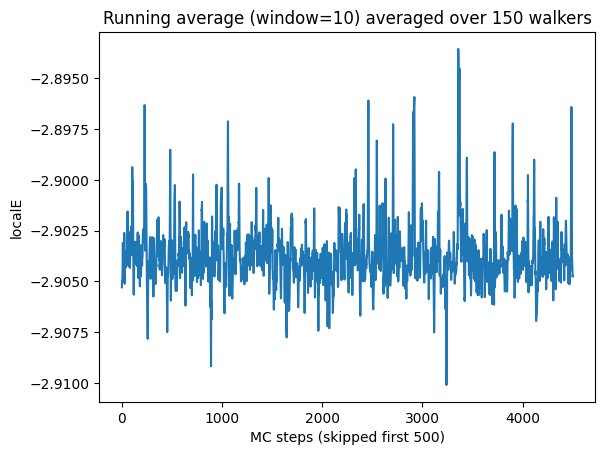

In [75]:
plt.plot(running_avg)
plt.title(f"Running average (window=10) averaged over {150} walkers")
plt.xlabel("MC steps (skipped first 500)")
plt.ylabel("localE")

Text(0.5, 1.0, 'Running average (window=10) averaged over 150 walkers')

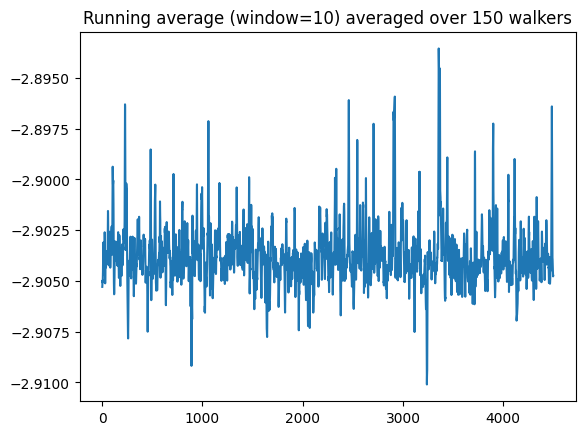

In [74]:
plt.plot(exp_running_avg)
plt.title(f"Running average (window=10) averaged over {150} walkers")

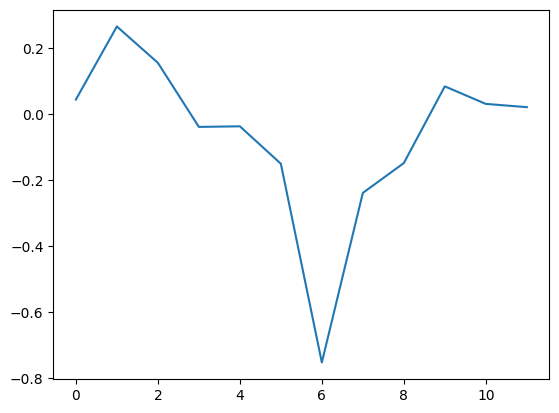

In [77]:
plt.plot(torch.stack(energies).detach())

Incoporate skipping the first n steps in local energy and gradient calulations